/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_18683/2014835398.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(D.img), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)


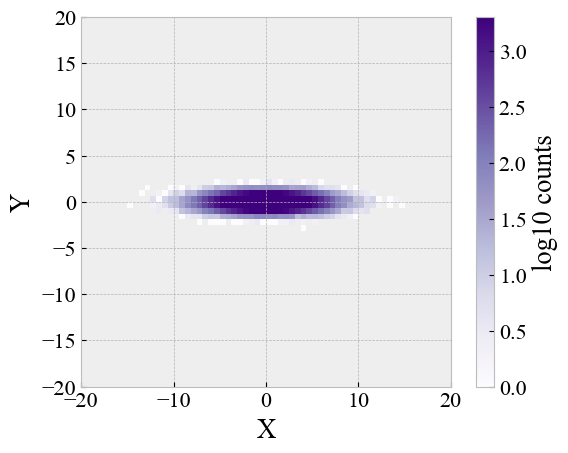

/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_18683/2014835398.py:48: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(E1.reconstruction), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)


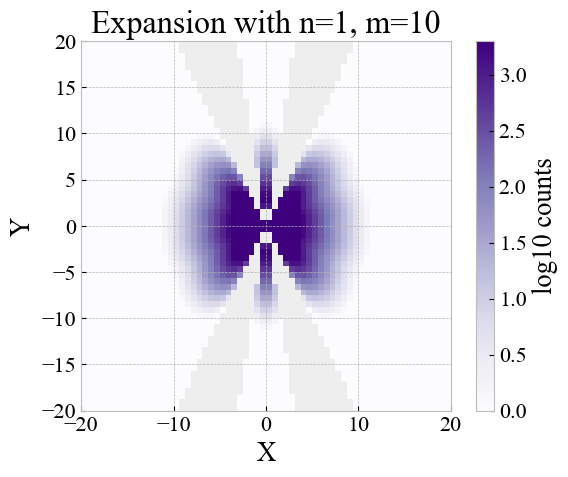

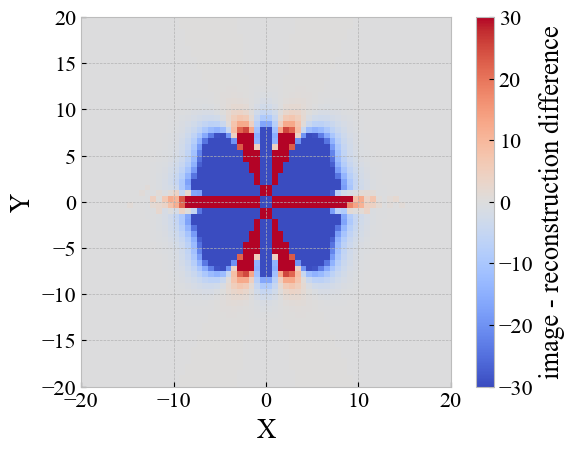

In [104]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py

#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')

# DiscModel is in a different file
from src.DiscModel import DiscGalaxy

N = 1000000 # number of stars in the disc

a = 1.0 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

inclinationvalue = 80. # no inclination (0) (face-on) , in degrees

D.rotate_disc(inclinationvalue,0,0)

# this image is tough to expand (but more realistic)
D.generate_image(rmax=20.,nbins=64,noiselevel=0.5)

# this image is easier to expand (but less realistic): a good starting point
#D.generate_image(rmax=8.,nbins=512,noiselevel=0.5)


E = D.make_expansion(10, 10, a)

# Plot the 2D histogram
plt.imshow(np.log10(D.img), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)
plt.colorbar(label='log10 counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

m=10
n=1
#Toggle this to see the expansion coefficients and how they change, goal: find the closest match to the image
E1 = D.make_expansion(m,n,a,noisy=False)

# (re)construct an image from the expansion coefficients
E1.laguerre_reconstruction(D.r,D.p)


plt.imshow(np.log10(E1.reconstruction), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)
plt.colorbar(label='log10 counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Expansion with n={n}, m={m}')
plt.show()

plt.figure()
# why is there a 3%ish bias here?
plt.imshow(D.img - 1.03*E1.reconstruction, origin='lower', cmap='coolwarm', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=-30.,vmax=30.)
plt.colorbar(label='image - reconstruction difference')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()




mmax: 100%|██████████| 19/19 [00:03<00:00,  6.11it/s]

Best match: mmax = 3, nmax = 4, NRMSE = 0.01245



/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_18683/1464105188.py:59: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_orig), origin='lower', cmap='Purples',


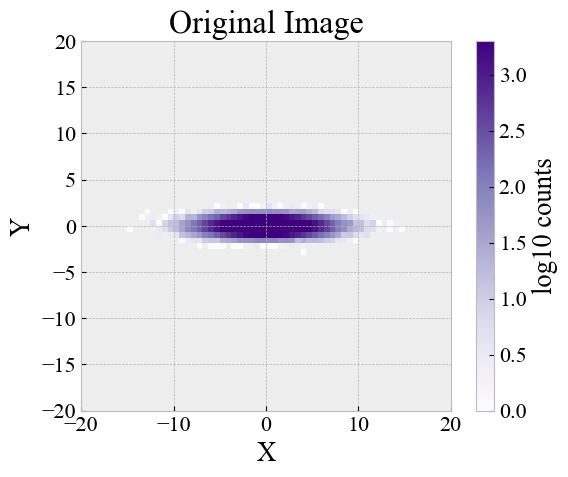

/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_18683/1464105188.py:70: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(best_E.reconstruction), origin='lower', cmap='Purples',


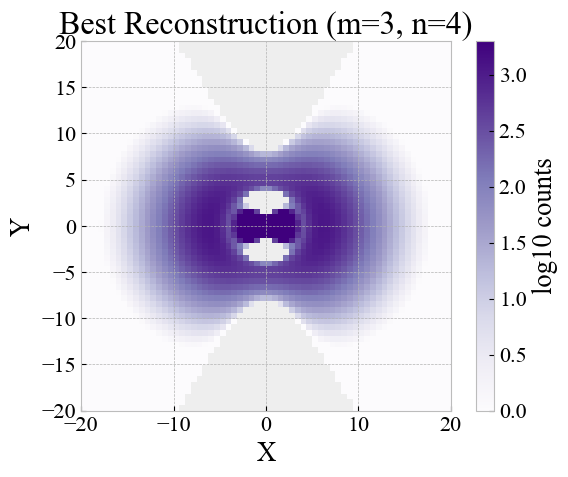

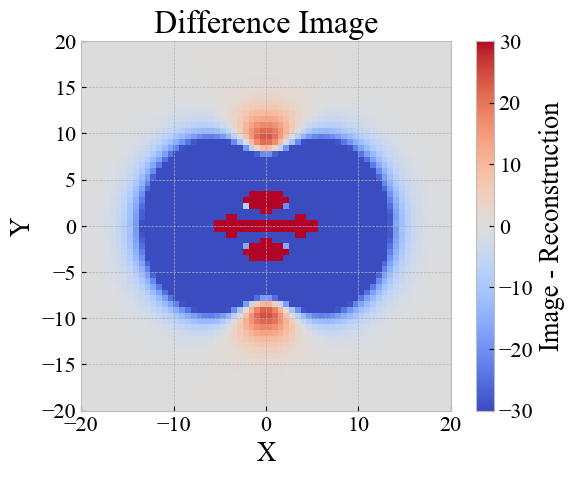

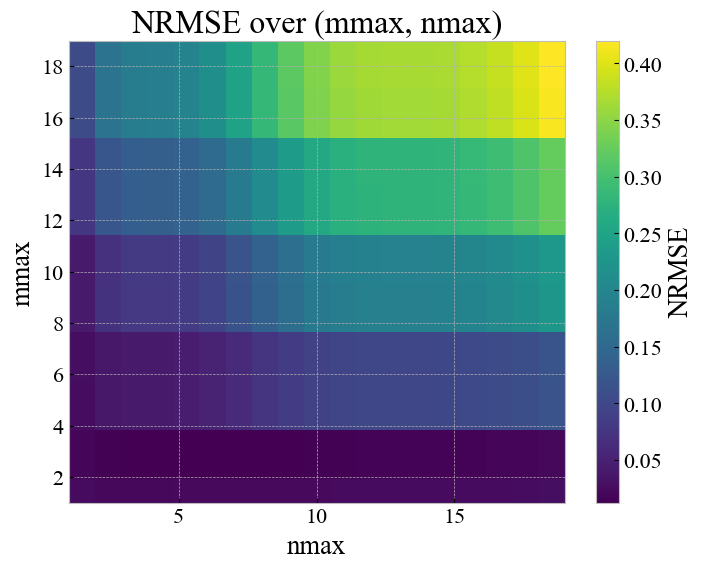

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.DiscModel import DiscGalaxy  # adjust if needed

# ---- Setup ----
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')

N = 1000000
a = 1.0
rmax = 20.
nbins = 64
noise = 0.5
inclinationvalue = 80.

D = DiscGalaxy(N=N, a=a)
D.rotate_disc(inclinationvalue, 0, 0)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)

img_orig = D.img.copy()
x_edges, y_edges = D.x_edges, D.y_edges

# ---- Optimization Grid ----
m_values = range(1, 20, 1)
n_values = range(1, 20, 1)
errors = []
best_error = np.inf
best_config = None
best_E = None

for m in tqdm(m_values, desc="mmax"):
    for n in n_values:
        try:
            E = D.make_expansion(m, n, a)
            E.laguerre_reconstruction(D.r, D.p)
            recon = E.reconstruction

            mask = np.isfinite(img_orig) & np.isfinite(recon)
            nrmse = np.sqrt(np.mean((img_orig[mask] - recon[mask])**2)) / np.max(img_orig)

            errors.append((m, n, nrmse))

            if nrmse < best_error:
                best_error = nrmse
                best_config = (m, n)
                best_E = E
        except Exception as e:
            print(f"Failed at m={m}, n={n}: {e}")

# ---- Results ----
m_best, n_best = best_config
print(f"Best match: mmax = {m_best}, nmax = {n_best}, NRMSE = {best_error:.5f}")

# ---- Plot: Original Image ----
plt.figure()
plt.imshow(np.log10(img_orig), origin='lower', cmap='Purples',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10 counts')
plt.title("Original Image")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# ---- Plot: Best Reconstruction ----
plt.figure()
plt.imshow(np.log10(best_E.reconstruction), origin='lower', cmap='Purples',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0., vmax=3.3)
plt.colorbar(label='log10 counts')
plt.title(f"Best Reconstruction (m={m_best}, n={n_best})")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# ---- Plot: Difference Image ----
plt.figure()
plt.imshow(img_orig - best_E.reconstruction, origin='lower', cmap='coolwarm',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=-30, vmax=30)
plt.colorbar(label='Image - Reconstruction')
plt.title("Difference Image")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# ---- Plot: Error Heatmap ----
m_grid = sorted(set(e[0] for e in errors))
n_grid = sorted(set(e[1] for e in errors))
Z = np.full((len(m_grid), len(n_grid)), np.nan)

for m, n, err in errors:
    i = m_grid.index(m)
    j = n_grid.index(n)
    Z[i, j] = err

plt.figure(figsize=(8,6))
plt.imshow(Z, origin='lower', aspect='auto',
           extent=[min(n_grid), max(n_grid), min(m_grid), max(m_grid)],
           cmap='viridis')
plt.colorbar(label='NRMSE')
plt.xlabel('nmax')
plt.ylabel('mmax')
plt.title('NRMSE over (mmax, nmax)')
plt.show()


[[ 4.97920291e+02  2.79995344e+02  2.18599918e+02  1.84929718e+02
   1.62400145e+02  1.45743807e+02  1.32641321e+02  1.21920090e+02
   1.12878048e+02  1.05071292e+02]
 [ 5.82081855e-01  7.43864915e-01  8.34803164e-01  8.83525858e-01
   9.02248772e-01  8.99483268e-01  8.81981429e-01  8.54751725e-01
   8.20894930e-01  7.81981895e-01]
 [-9.11188613e+02 -4.47282248e+02 -3.06681646e+02 -2.26977818e+02
  -1.73072225e+02 -1.33412370e+02 -1.02740826e+02 -7.83014339e+01
  -5.83998578e+01 -4.19340097e+01]
 [-1.39702336e+00 -1.76124867e+00 -1.95593123e+00 -2.04772718e+00
  -2.06535659e+00 -2.03004415e+00 -1.95934311e+00 -1.86642741e+00
  -1.75925363e+00 -1.64151390e+00]
 [ 7.86726183e+02  2.86328179e+02  1.24997423e+02  3.26520716e+01
  -2.88801015e+01 -7.27569021e+01 -1.05197907e+02 -1.29587507e+02
  -1.48054972e+02 -1.62016580e+02]
 [ 1.67111554e+00  2.06031547e+00  2.25134944e+00  2.31763438e+00
   2.29129175e+00  2.19903708e+00  2.06464381e+00  1.90628731e+00
   1.73446756e+00  1.55323931e+00

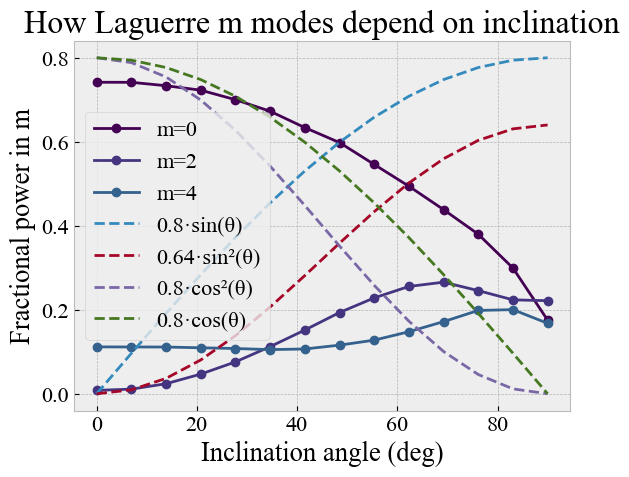

In [110]:

with h5py.File("example_galaxy.hdf5", "a") as f:
    group = f.require_group("f444w/00001_expansion")
    
    # Remove datasets if they exist
    for dname in ["coscoefs", "sincoefs"]:
        if dname in group:
            del group[dname]
    
    # Now safely create
    group.create_dataset("coscoefs", data=E.coscoefs)
    group.create_dataset("sincoefs", data=E.sincoefs)
    group.attrs["inclination_angle_deg"] = inclinationvalue

print(E.coscoefs)
print(E.sincoefs)

import matplotlib.pyplot as plt
import numpy as np
from src.DiscModel import DiscGalaxy

# Parameters
N = 1000000
a = 1.0
rmax = 8.
nbins = 512
mmax = 10
nmax = 10

# Inclination angles to test
inclinations = [0, 30, 60, 85]

#prepare figure
#fig, axs = plt.subplots(2, len(inclinations), figsize=(4*len(inclinations), 8))

for idx, inc in enumerate(inclinations):
    # Generate galaxy
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_expansion(mmax, nmax, a)
    
    # Compute magnitude of coefficients
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    
    # Sum over m to get total power per m
    m_power = np.sum(coef_mag, axis=1)
    
    
    n_power = np.sum(coef_mag, axis=0)
    """
    # Plot
    axs[0, idx].bar(range(mmax+1), m_power)
    axs[0, idx].set_title(f"Inclination {inc}°: Power vs m")
    axs[0, idx].set_xlabel('m')
    axs[0, idx].set_ylabel('Total Power')
    
    axs[1, idx].bar(range(nmax), n_power)
    axs[1, idx].set_title(f"Inclination {inc}°: Power vs n")
    axs[1, idx].set_xlabel('n')
    axs[1, idx].set_ylabel('Total Power')
    """

#plt.tight_layout()
#plt.show()


N = 1_000_000
a = 1.0
rmax = 11.
nbins = 512
mmax = 10
nmax = 10
inclinations = np.linspace(0, 90, 14)  # Inclination angles from 0 to 85 degrees
colormap = plt.cm.viridis(np.linspace(0, 1, len(inclinations)))
# Store results
results = []

for inc in inclinations:
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_expansion(mmax, nmax, a)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    total_power = np.sum(m_power)
    frac_power = m_power / total_power
    
    results.append({
        "inclination": inc,
        "m_power": m_power,
        "frac_power": frac_power
    })

# Plot fractional power vs inclination for each m
theta_deg = np.array([r["inclination"] for r in results])
theta_rad = np.radians(theta_deg)

for m in range(0,5,2):
    plt.plot(theta_deg,
             [r["frac_power"][m] for r in results],
             marker='o', label=f"m={m}", color=colormap[m])

# Overplot trigonometric functions
plt.plot(theta_deg, 0.8*np.sin(theta_rad), '--', label='0.8·sin(θ)')
plt.plot(theta_deg, 0.64*np.sin(theta_rad)**2, '--', label='0.64·sin²(θ)')
plt.plot(theta_deg, 0.8*np.cos(theta_rad)**2, '--', label='0.8·cos²(θ)')
plt.plot(theta_deg, 0.8*np.cos(theta_rad), '--', label='0.8·cos(θ)')

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Fractional power in m")
plt.legend()
plt.title("How Laguerre m modes depend on inclination")
plt.show()


Computing expansions: 100%|██████████| 20/20 [00:02<00:00,  6.97it/s]


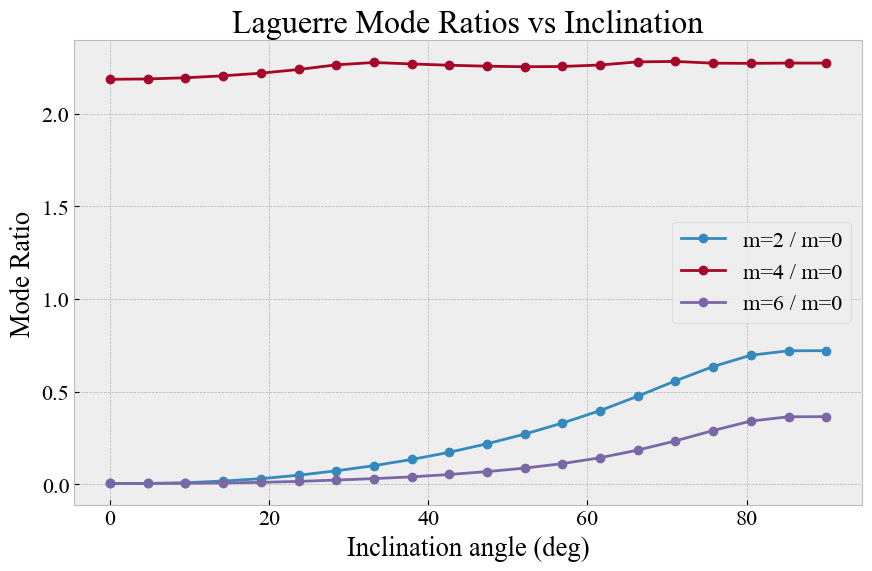

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.DiscModel import DiscGalaxy

# --- Configuration ---
N = 1000000
a = 1.0
rmax = 20.
nbins = 64
noise = 0.5
mmax = 10
nmax = 10

# Inclination angles to scan
inclinations = np.linspace(0, 90, 20)

# Store results
results = []

# --- Compute fractional power for each inclination ---
for inc in tqdm(inclinations, desc="Computing expansions"):
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    E = D.make_expansion(mmax, nmax, a)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    total_power = np.sum(m_power)
    frac_power = m_power / total_power
    
    results.append({
        "inclination": inc,
        "frac_power": frac_power
    })

# --- Extract and compute ratios ---
theta_deg = np.array([r["inclination"] for r in results])
P0 = np.array([r["frac_power"][0] for r in results])
P2 = np.array([r["frac_power"][2] for r in results])
P4 = np.array([r["frac_power"][4] for r in results])
P6 = np.array([r["frac_power"][6] for r in results])

R2 = P2 / P0
R4 = P4 / P0
R6 = P6 / P0

# --- Plot ratios with sine/cosine overlays ---
theta_rad = np.radians(theta_deg)

plt.figure(figsize=(9, 6))

plt.plot(theta_deg, R2, 'o-', label='m=2 / m=0')
plt.plot(theta_deg, R4, 'o-', label='m=4 / m=0')
plt.plot(theta_deg, R6, 'o-', label='m=6 / m=0')

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Mode Ratio")
plt.title("Laguerre Mode Ratios vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_18683/2425514441.py:46: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Times New Roman.
  plt.tight_layout()
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_18683/2425514441.py:46: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Times New Roman.
  plt.tight_layout()
/Users/Megan/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Megan/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)


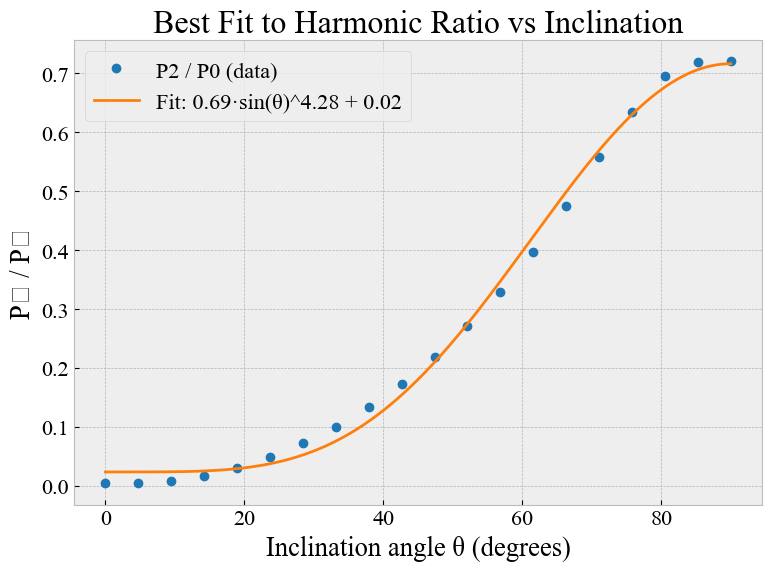

Best fit model:
  R(θ) = 0.693·sin(θ)^4.282 + 0.023
RMSE = 0.01651


In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === STEP 1: Data ===
# Replace with your real results
theta_deg = np.array([r["inclination"] for r in results])
P0 = np.array([r["frac_power"][0] for r in results])
P2 = np.array([r["frac_power"][2] for r in results])
P4 = np.array([r["frac_power"][4] for r in results])
P6 = np.array([r["frac_power"][6] for r in results])

R2 = P2 / P0
R4 = P4 / P0
R6 = P6 / P0
                    # mode ratio

# === STEP 2: Fit Model ===
# Example model: A * sin(theta)^C + D
def model(theta_deg, A, C, D):
    theta_rad = np.radians(theta_deg)
    return A * np.sin(theta_rad)**C + D

# Fit the model
popt, pcov = curve_fit(model, theta_deg, R2, p0=[0.5, 2.0, 0.0])
A_fit, C_fit, D_fit = popt

# Evaluate the fit
theta_fit = np.linspace(0, 90, 500)
R_fit = model(theta_fit, *popt)

# === STEP 3: Compute RMSE ===
R2_pred = model(theta_deg, *popt)
rmse = np.sqrt(np.mean((R2 - R2_pred)**2))

# === STEP 4: Plot ===
plt.figure(figsize=(8,6))
plt.plot(theta_deg, R2, 'o', label='P2 / P0 (data)', color='tab:blue')
plt.plot(theta_fit, R_fit, '-', label=f'Fit: {A_fit:.2f}·sin(θ)^{C_fit:.2f} + {D_fit:.2f}', color='tab:orange')

plt.xlabel("Inclination angle θ (degrees)")
plt.ylabel("P₂ / P₀")
plt.title("Best Fit to Harmonic Ratio vs Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print formula and RMSE
print(f"Best fit model:\n  R(θ) = {A_fit:.3f}·sin(θ)^{C_fit:.3f} + {D_fit:.3f}")
print(f"RMSE = {rmse:.5f}")
